# Skin Cancer detection using Convolutional Neural Network

> The dataset used in this project is "Human Against Machine with 10000 training images" dataset which contains up to 10015 dermatoscopic images of skin lesions. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
> * Actinic keratoses (akiec)
> * basal cell carcinoma (bcc)
> * benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
> * dermatofibroma (df)
> * melanoma (mel)
> * melanocytic nevi (nv) 
> * vascular lesions <br>
>
> Out of these seven types of skin lesions two of them are skin cancer. The most common type of skin cancer is Basal cell carcinoma and then Melanoma is the most serious form of skin cancer because of its tendency to spread. Also Actinic keratoses (AKs) are not technically considered a cancer or a malignant disease, but they are a precancerous or potentially malignant condition. AKs are scaly or crusty growths on the skin that typically occur in areas exposed to the sun, and they are caused by long-term sun exposure. While most AKs do not become cancerous, they can develop into squamous cell carcinoma (SCC), a type of skin cancer, if left untreated.

In [1]:
# Import necessities
from glob import glob
import os

import cv2
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score
from collections import defaultdict

# Magic incantation to help matplotlib work with our jupyter notebook.
%matplotlib inline 

import warnings;
warnings.filterwarnings('ignore');

# Random seed for consistent results.
seed = 42

#### Data and Visualization

In [2]:
# Metadata
skin_meta = pd.read_csv('HAM10000_metadata.csv')

In [3]:
# Creating dictionary for displaying more human-friendly labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
# Merge images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('*', '*.jpg'))}

In [5]:
# Creating new columns for better understanding of features
skin_meta['path'] = skin_meta['image_id'].map(imageid_path_dict.get)
skin_meta['Cell type'] = skin_meta['dx'].map(lesion_type_dict.get)
skin_meta['target'] = pd.Categorical(skin_meta['Cell type']).codes

In [6]:
skin_meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,Cell type,target
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [7]:
# Look for missing data
skin_meta.isna().sum()
# Replace with the mean 
skin_meta['age'].fillna((skin_meta['age'].mean()), inplace=True)

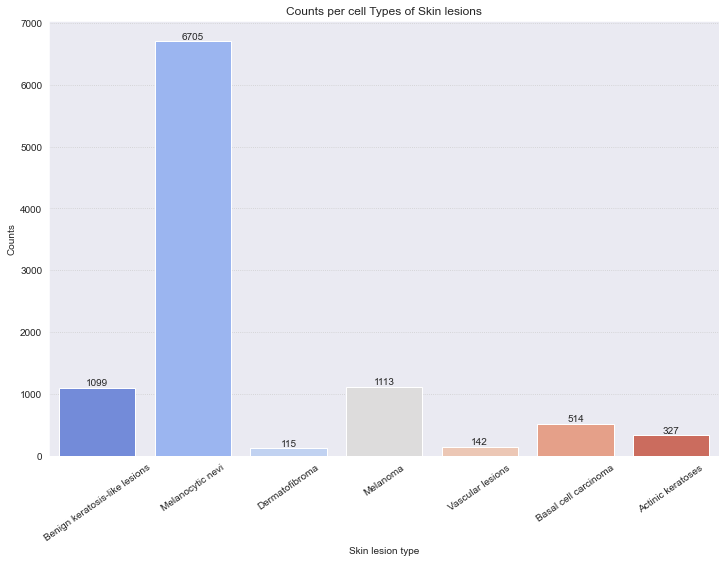

In [8]:
# Barplot with Counts per cell Types of Skin lesions
sns.set_style('darkgrid', {"grid.color": ".8", "grid.linestyle": ":"})
fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x = 'Cell type', data = skin_meta, palette = 'coolwarm')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Counts per cell Types of Skin lesions')
plt.ylabel('Counts')
plt.xlabel('Skin lesion type')
plt.xticks(rotation=35)
plt.show()

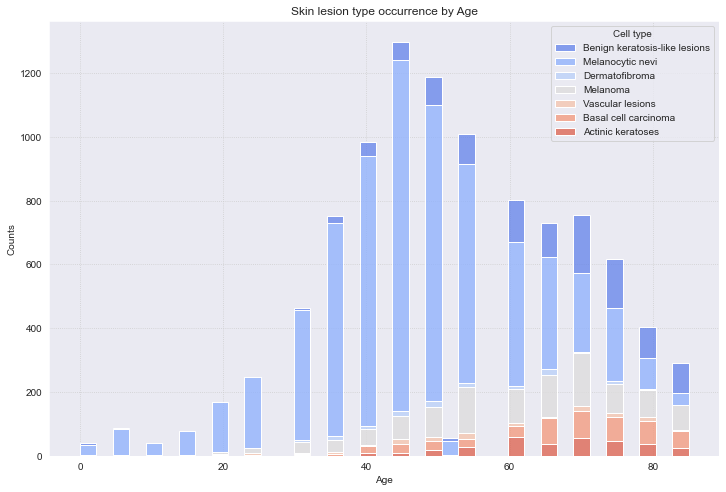

In [9]:
# Skin lesion type occurence by Age
sns.set_style('darkgrid', {"grid.color": ".8", "grid.linestyle": ":"})
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data = skin_meta, x = 'age', hue = 'Cell type', multiple='stack', palette='coolwarm')
plt.title('Skin lesion type occurrence by Age')
plt.ylabel('Counts')
plt.xlabel('Age')
plt.show()

#### Preprocess

In [10]:
# Create a column 'label' with categories of malignant and non-malignant skin lesions
def lesion_type(row):
    if row['dx'] == 'bkl' or row['dx'] == 'df' or row['dx'] == 'nv' or row['dx'] == 'vasc' :           
        return 0 # 'benign'
    elif row['dx'] == 'akiec' or row['dx'] == 'mel' or row['dx'] == 'bcc' :
        return 1 # 'malignant'
    
skin_meta = skin_meta.assign(label = skin_meta.apply(lesion_type, axis=1))

In [11]:
# Save the images as an array
skin_meta['image'] = skin_meta['path'].map(lambda x: np.asarray(Image.open(x)))

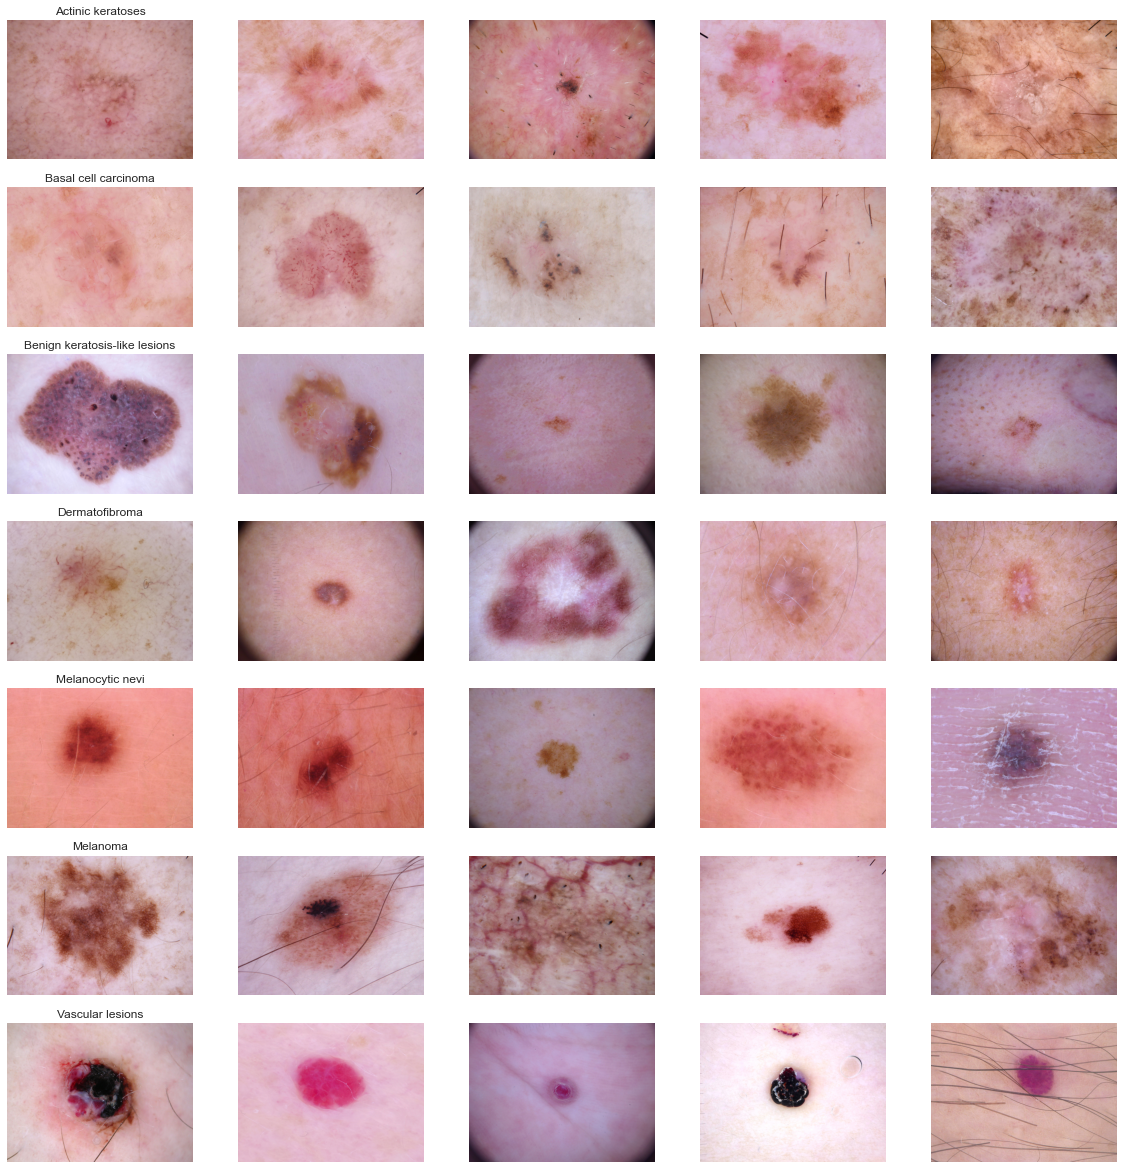

In [12]:
# Pictorial representation of the images of dataset
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_meta.sort_values(['Cell type']).groupby('Cell type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = seed).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [13]:
# Create a balanced dataset to use later in the models
skin_0 = skin_meta[skin_meta['label'] == 0]
skin_1 = skin_meta[skin_meta['label'] == 1]

n_samples = 200 
skin_0_balanced = resample(skin_0, replace=True, n_samples=n_samples, random_state=seed) 
skin_1_balanced = resample(skin_1, replace=True, n_samples=n_samples, random_state=seed) 

skin_200 = pd.concat([skin_0_balanced, skin_1_balanced])
skin_200 = skin_200.reset_index()

In [14]:
skin_meta['image'][0].shape

(450, 600, 3)

The shape indicates that the image is a rectangular grid of 450 rows and 600 columns, with three color channels per pixel.

In [15]:
# Function to display the images
def show_images(img_list, rows, columns, titles_list=[], show_axes="off"):
    w = 20 if columns >= 3 else 10;
    h = 20 if rows >= 3 else 10;
    plt.figure(figsize=(w, h))
    index = 0;
    
    for row in range(rows):
        for column in range(columns):
            index += 1
            plt.subplot(rows, columns, index)
            plt.axis(show_axes)
            plt.imshow(img_list[index-1], cmap="gray")
            
            if len(titles_list) > 0:
                plt.title(titles_list[index-1])

#### Create Segmented images

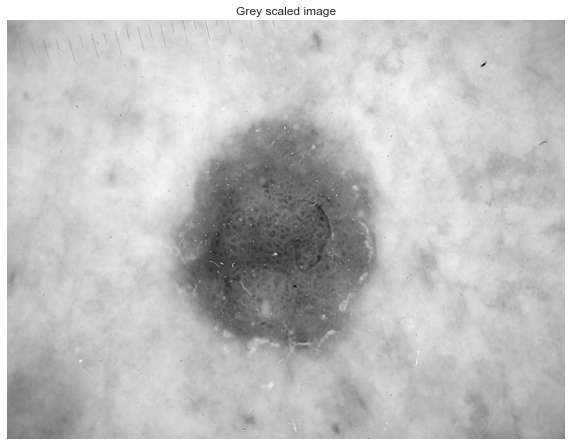

In [16]:
img = skin_meta['image'][50]
# Method to convert an image from one color space to another.
image_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_images([image_gr], 1,1, ["Grey scaled image"])

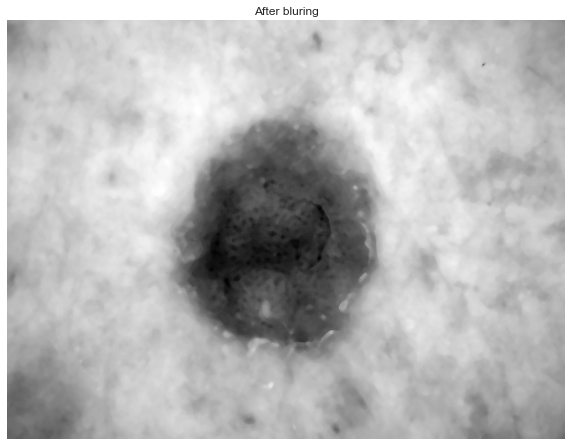

In [17]:
image_blur = cv2.medianBlur(image_gr, 5)
show_images([image_blur], 1,1, ["After bluring"])

In [18]:
otsu_threshold, image_result = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

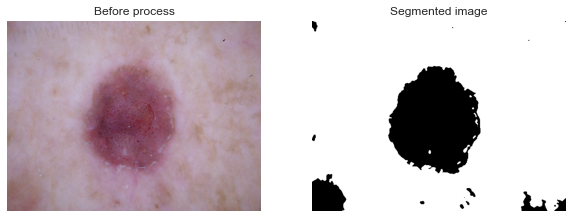

In [19]:
# Display the thresholded image
show_images([img, image_result], 1, 2, ["Before process", "Segmented image"])

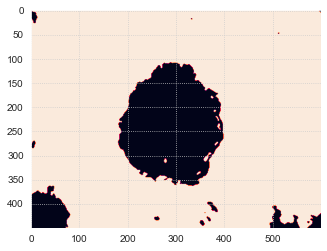

In [20]:
plt.imshow(image_result)
plt.show()

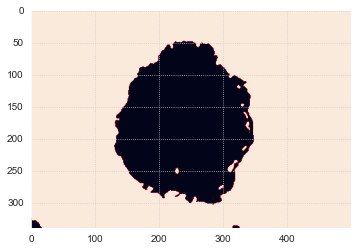

0


In [21]:
# Crop the images to capture the lesion more precisely
image_result_cropped = image_result[60:400,50:550]
plt.imshow(image_result_cropped)
plt.show()
image_result_cropped = cv2.bitwise_not(image_result_cropped)
print(image_result_cropped[0][0])

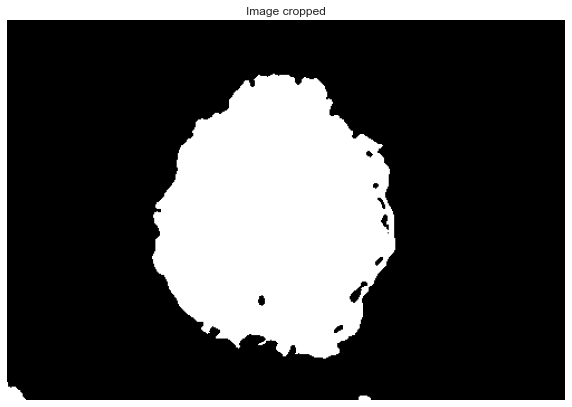

In [22]:
show_images([image_result_cropped], 1,1, ["Image cropped"])

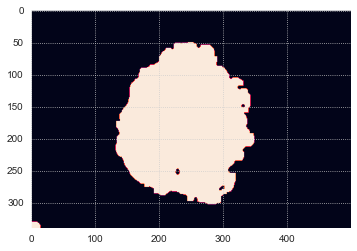

In [23]:
kernel = np.ones((8,8),np.uint8)
opening = cv2.morphologyEx(image_result_cropped, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)
plt.show()

In [24]:
# Create a folder in the directory to save inside the segmented images
folder_name = "Segmented_images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [25]:
def create_segmented_pictures(images_array, skin_200, folder_name):
    kernel = np.ones((8,8), np.uint8)
    skin_200['segmented_image'] = ''
    for i in range(len(images_array)):
        image_gr = cv2.cvtColor(images_array[i], cv2.COLOR_BGR2GRAY)
        image_blur = cv2.medianBlur(image_gr, 5)
        otsu_threshold, image_result = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        image_cropped = image_result[60:400, 50:550]
        image_cropped = cv2.bitwise_not(image_cropped)

        # Save the image in the file "Segmented_images"
        skin_200['segmented_image'][i] = np.array(image_cropped).astype(np.uint8)
        
        image_saved = Image.fromarray(image_cropped)
        image_seg_id = skin_200['image_id'][i]
        image_saved.save(f'{folder_name}/segmented_{image_seg_id}.jpg', 'JPEG')

In [26]:
create_segmented_pictures(skin_200['image'], skin_200, "Segmented_images")

# Part 1

#### Feature Engineering

Calculate perimeter..

In [27]:
def calculate_perimeter(images_array):
    skin_200['perimeter'] = ''
    for i in range(len(images_array['segmented_image'])):
        # Find contours in the binary image
        image = images_array['segmented_image'][i]
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Compute the perimeter of the largest contour
        skin_200['perimeter'][i] = cv2.arcLength(contours[0], True) if len(contours) > 0 else 0

calculate_perimeter(skin_200)

Calculate non zero pixels..

In [28]:
def calculate_non_zeros(images_array):
    skin_200['non_zeros'] = ''
    for i in range(len(images_array['segmented_image'])):

        image = images_array['segmented_image'][i]
        skin_200['non_zeros'][i] = np.count_nonzero(image)

calculate_non_zeros(skin_200)

Calculate circularity..

In [29]:
def calculate_circularity(images_array):
    skin_200['circularity'] = ''
    for i in range(len(images_array['segmented_image'])):
        
        image = images_array['segmented_image'][i]
        
        contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(max_contour, True)
        area = cv2.contourArea(max_contour)
        skin_200['circularity'][i] = (4*np.pi*area) / (perimeter*perimeter)

calculate_circularity(skin_200)

Calculate assymetry..

In [30]:
def calculate_assymetry(images_array):
    skin_200['main_assymetry'] = ''
    skin_200['secondary_assymetry'] = ''
    for i in range(len(images_array['segmented_image'])):
        
        image = images_array['segmented_image'][i]
        # Find contours in the binary image
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv2.contourArea)
        
        # Compute the moments of the contour
        moments = cv2.moments(max_contour)

        # Compute the centroid of the contour
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])

        # Compute the first and second moments of the contour
        m11 = moments["m11"] - cx * moments["m01"]
        m20 = moments["m20"] - cx * moments["m10"]
        m02 = moments["m02"] - cy * moments["m01"]

        # Compute the degree of asymmetry to the first axis of symmetry
        theta1 = 0.5 * np.arctan2(2 * m11, m20 - m02)
        skin_200['main_assymetry'][i] = np.abs(m20 * np.sin(theta1)**2 - 2 * m11 * np.sin(theta1) * np.cos(theta1) + m02 * np.cos(theta1)**2) / (m20 + m02)

        # Compute the degree of asymmetry to the second axis of symmetry
        theta2 = 0.5*np.arctan2(2*m11, -(m20 - m02))
        skin_200['secondary_assymetry'][i] = np.abs(m20 * np.sin(theta2)**2 - 2 * m11 * np.sin(theta2) * np.cos(theta2) + m02 * np.cos(theta2)**2) / (m20 + m02)

calculate_assymetry(skin_200)

Create plit RGB channels..

In [31]:
def split_channels(images_array):
    skin_200['r_channel'] = ''
    skin_200['g_channel'] = ''
    skin_200['b_channel'] = ''
    for i in range(len(images_array['image'])):
        
        image = images_array['image'][i]
        image_cropped = image[60:400, 50:550]
        # Use only the pixels that are in the segmented image
        red, green, blue = cv2.split(image_cropped)
        skin_200['r_channel'][i] = red
        skin_200['g_channel'][i] = green
        skin_200['b_channel'][i]  = blue

split_channels(skin_200)

Following let's view an example..

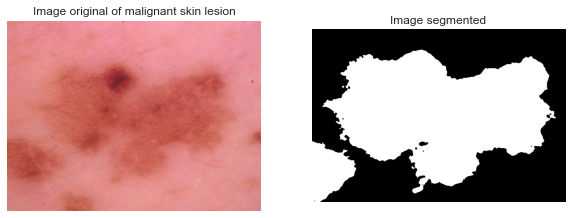

In [32]:
show_images([skin_200['image'][110], skin_200['segmented_image'][110]], 1,2, ["Image original of malignant skin lesion", "Image segmented"])

In [33]:
img = skin_200['segmented_image'][110]

Pixel amount of the outline:  1784.653
Amount of non-zero pixels:  84446
Circularity of the largest contour:  0.3042
Degree of asymmetry to the first axis of symmetry:  0.2229
Degree of asymmetry to the second axis of symmetry:  0.7756


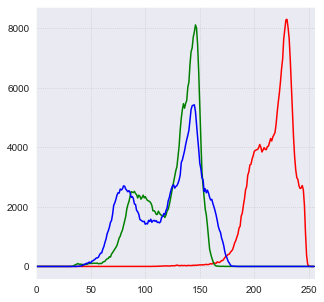

In [34]:
# Find contours in the binary image
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the pixel amount of the outline
contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
perimeter = cv2.arcLength(cnt, True)

# Calculate the amount of non-zero pixels
non_zero = np.count_nonzero(img)

# Calculate the circularity of the largest contour
max_contour = max(contours, key=cv2.contourArea)
perimeter = cv2.arcLength(max_contour, True)
area = cv2.contourArea(max_contour)
circularity = (4*np.pi*area) / (perimeter*perimeter)
    
# Compute the moments of the contour
moments = cv2.moments(max_contour)

# Compute the centroid of the contour
cx = int(moments["m10"] / moments["m00"])
cy = int(moments["m01"] / moments["m00"])

# Compute the first and second moments of the contour
m11 = moments["m11"] - cx*moments["m01"]
m20 = moments["m20"] - cx*moments["m10"]
m02 = moments["m02"] - cy*moments["m01"]

# Compute the degree of asymmetry to the first axis of symmetry
theta1 = 0.5*np.arctan2(2*m11, m20 - m02)
asymmetry1 = np.abs(m20*np.sin(theta1)**2 - 2*m11*np.sin(theta1)*np.cos(theta1) + m02*np.cos(theta1)**2) / (m20 + m02)

# Compute the degree of asymmetry to the second axis of symmetry
theta2 = 0.5*np.arctan2(2*m11, -(m20 - m02))
asymmetry2 = np.abs(m20*np.sin(theta2)**2 - 2*m11*np.sin(theta2)*np.cos(theta2) + m02*np.cos(theta2)**2) / (m20 + m02)

# Print the results
print("Pixel amount of the outline: ", round((perimeter), 4))
print("Amount of non-zero pixels: ", non_zero)
print("Circularity of the largest contour: ", round((circularity), 4))
print("Degree of asymmetry to the first axis of symmetry: ", round((asymmetry1), 4))
print("Degree of asymmetry to the second axis of symmetry: ", round((asymmetry2), 4))

image = skin_200['image'][110]
# Create RGB histogram 
plt.figure(figsize=(5, 5))
red, green, blue = cv2.split(image)
color = ('r','g','b')
for i, col in enumerate(color):
    hist_c = cv2.calcHist([image], [i], None, [256],[0, 256])
    plt.plot(hist_c, color = col)
    plt.xlim([0,256])

#### Machine Learning Classification 

In [35]:
skin_features = skin_200[['perimeter', 'non_zeros', 'circularity',
       'main_assymetry', 'secondary_assymetry', 'r_channel', 'g_channel',
       'b_channel', 'label']]

In [36]:
skin_features = skin_features.sample(frac=1, random_state=seed)

In [37]:
skin_features.head()

,perimeter,non_zeros,circularity,main_assymetry,secondary_assymetry,r_channel,g_channel,b_channel,label
209,4.0,80411,0.393735,0.38991,0.417272,"[[208, 208, 208, 209, 207, 210, 210, 212, 210,...","[[172, 172, 168, 169, 170, 171, 171, 173, 176,...","[[172, 176, 176, 177, 177, 174, 172, 176, 177,...",1
280,15.071068,30729,0.428898,0.349385,0.419811,"[[78, 80, 83, 84, 80, 84, 84, 80, 83, 87, 91, ...","[[42, 42, 44, 45, 49, 50, 53, 54, 52, 53, 59, ...","[[46, 41, 39, 40, 47, 48, 48, 53, 50, 43, 44, ...",1
33,15.656854,48077,0.22985,0.258435,0.368007,"[[222, 222, 222, 221, 224, 219, 223, 221, 223,...","[[139, 138, 139, 138, 141, 139, 145, 145, 147,...","[[159, 161, 165, 166, 171, 168, 171, 171, 173,...",0
210,4.0,10367,0.233145,0.216059,0.34479,"[[56, 63, 66, 68, 68, 71, 72, 75, 81, 82, 82, ...","[[43, 46, 49, 49, 53, 56, 57, 61, 65, 66, 70, ...","[[34, 39, 42, 43, 48, 51, 50, 52, 52, 53, 58, ...",1
93,7.414214,120960,0.25222,0.237358,0.762493,"[[236, 235, 235, 237, 244, 241, 238, 240, 238,...","[[150, 153, 155, 159, 165, 165, 162, 164, 160,...","[[159, 159, 164, 157, 170, 169, 166, 166, 160,...",0


In [38]:
skin_features['perimeter'] = skin_features['perimeter'].astype(float)
skin_features['non_zeros'] = skin_features['perimeter'].astype(float)
skin_features['circularity'] = skin_features['perimeter'].astype(float)
skin_features['main_assymetry'] = skin_features['perimeter'].astype(float)
skin_features['secondary_assymetry'] = skin_features['perimeter'].astype(float)

PCA can be used to reduce the dimensionality of the data by finding the principal components, which capture the most significant variation in the data. Once you have identified the principal components, you can project the data onto these components, resulting in a lower-dimensional representation of the original data.

In [39]:
# create a PCA object with n_components=1
pca = PCA(n_components=1)

In [40]:
for channel in ['r_channel', 'g_channel', 'b_channel']:
    # Create PCA object with 1 component
    pca = PCA(n_components=1)

    # Apply PCA to each row in the channel column and save the result in the same place
    skin_features[channel] = skin_features[channel].apply(lambda x: pca.fit_transform(x).flatten()[0])

In [41]:
skin_features.head()

,perimeter,non_zeros,circularity,main_assymetry,secondary_assymetry,r_channel,g_channel,b_channel,label
209,4.000000,4.000000,4.000000,4.000000,4.000000,269.442439,492.239144,722.176629,1
280,15.071068,15.071068,15.071068,15.071068,15.071068,-28.440450,-146.162552,-180.485049,1
33,15.656854,15.656854,15.656854,15.656854,15.656854,500.853794,600.211606,745.974730,0
210,4.000000,4.000000,4.000000,4.000000,4.000000,-226.357203,-262.311333,-332.772175,1
93,7.414214,7.414214,7.414214,7.414214,7.414214,367.319895,393.096753,431.328948,0


In [42]:
# Split into data and labels
labels = skin_features['label']
data = skin_features.drop('label', axis=1)

In [43]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=seed)

In [44]:
predictions = defaultdict(list)

def RandomForest(model, X_train, y_train, X_test, y_test, title):
    model = model
    hist = model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    predictions[title].append(y_pred)
    print('Model accuracy score with 10 decision-trees: {0:0.4f}%'. format(accuracy_score(y_test, y_pred) * 100))
    
    target_names = ['Melanoma', 'Non-melanoma']
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Normal', 'Actual Pathologic'], 
                                 index=['Predicted Normal', 'Predicted Pathologic'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')
    print('Confusion matrix:\n')
    return model

Model accuracy score with 10 decision-trees: 52.0000%
              precision    recall  f1-score   support

    Melanoma       0.52      0.58      0.55        50
Non-melanoma       0.52      0.46      0.49        50

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.52      0.52      0.52       100

Confusion matrix:



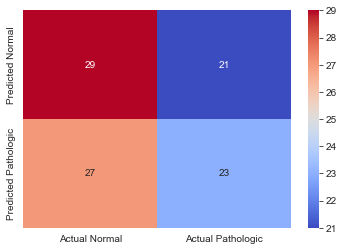

In [45]:
RF = RandomForest(RandomForestClassifier(random_state=seed), X_train, y_train, X_test, y_test, 'RF')

# Part 2

#### Convolutional Neural Networks 

In [46]:
# Function to plot loss during training
def plot_loss(model_fitting):
    plt.plot(model_fitting.history['loss'], label='train') 
    if 'val_loss' in model_fitting.history:
        plt.plot(model_fitting.history['val_loss'], label='test')
    plt.title('Model Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss values')
    plt.legend(loc='upper right')
    plt.show()
    
# Function to plot accuracy measurements during training-testing
def plot_accuracy(model_fitting):
    plt.plot(model_fitting.history['accuracy'], label='train')
    if 'val_accuracy' in model_fitting.history:
        plt.plot(model_fitting.history['val_accuracy'], label='test')
    plt.title('Model Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='upper right')
    plt.show()

In [51]:
# Split the data into training, validation, and test sets
df_train_val, df_test = train_test_split(skin_200, test_size=0.2, stratify=skin_200['label'])
df_train, df_val = train_test_split(df_train_val, test_size=0.25, stratify=df_train_val['label'])

# Define a function to load and preprocess images
def load_images(df, target_size=(224, 224)):
    images = []
    for i in range(len(df)):
        img = image.array_to_img(df.iloc[i]['image'])
        img = img.resize(target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images.append(x)
    return np.vstack(images)

# Load and preprocess the training, validation, and test images
X_train = load_images(df_train)
X_val = load_images(df_val)
X_test = load_images(df_test)
y_train = df_train['label']
y_val = df_val['label']
y_test = df_test['label']

# Load a pre-trained VGG16 model and remove the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers and compile the model
for layer in base_model.layers:
    layer.trainable = False
optimizer = SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).ravel()
accuracy = np.mean(y_pred == y_test)
print('Test accuracy:', accuracy)

Epoch 1/10
30/30 [==============================] - 16s 514ms/step - loss: 9.1095 - accuracy: 0.5583 - val_loss: 7.8083 - val_accuracy: 0.6750
Epoch 2/10
30/30 [==============================] - 15s 510ms/step - loss: 8.2063 - accuracy: 0.6667 - val_loss: 8.4360 - val_accuracy: 0.6000
Epoch 3/10
30/30 [==============================] - 15s 517ms/step - loss: 7.5354 - accuracy: 0.7375 - val_loss: 7.5557 - val_accuracy: 0.7000
Epoch 4/10
30/30 [==============================] - 15s 518ms/step - loss: 7.3102 - accuracy: 0.7875 - val_loss: 7.9457 - val_accuracy: 0.6500
Epoch 5/10
30/30 [==============================] - 15s 518ms/step - loss: 7.1520 - accuracy: 0.8458 - val_loss: 7.7190 - val_accuracy: 0.6625
Epoch 6/10
30/30 [==============================] - 16s 521ms/step - loss: 7.0880 - accuracy: 0.8958 - val_loss: 7.6139 - val_accuracy: 0.6625
Epoch 7/10
30/30 [==============================] - 16s 522ms/step - loss: 7.0554 - accuracy: 0.8875 - val_loss: 7.7451 - val_accuracy: 0.6875

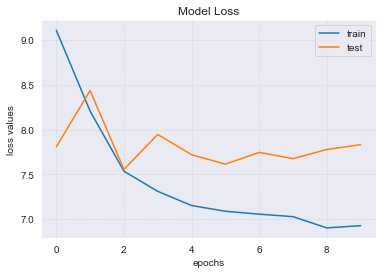

In [52]:
plot_loss(history)

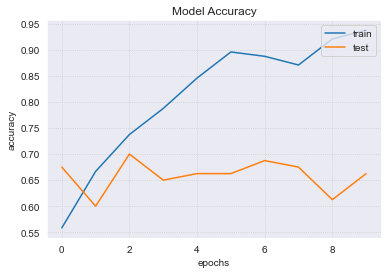

In [53]:
plot_accuracy(history)